# Импорт библиотек

In [1]:
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import Pool, CatBoostClassifier

In [2]:
pd.set_option('display.max_columns', 500) 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Чтение данных, ознакомление, анализ, предобработка

In [4]:
contract = pd.read_csv('/content/drive/My Drive/Colab Notebooks/contract.csv')
personal = pd.read_csv('/content/drive/My Drive/Colab Notebooks/personal.csv')
internet = pd.read_csv('/content/drive/My Drive/Colab Notebooks/internet.csv')
phone = pd.read_csv('/content/drive/My Drive/Colab Notebooks/phone.csv')

### Contract

In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


##### Выводы:
1. Названия столбцов указаны в верхнем регистре - перевести в нижний.
2. Значения в столбцах имеют верхний регистр - перевести в нижний.
3. Пропусков нет.
4. После перевода данных в нижний регистр - проверить на дубликаты.
5. Столбцы привести к нужным типам данных.

In [7]:
contract.columns = contract.columns.str.lower()
cols = ['type','paperlessbilling','paymentmethod']
for i in cols:
    contract[i] = contract[i].str.lower()
contract['begindate'] = pd.to_datetime(contract['begindate'])

##### В строках столбца 'totalcharges' пропущены значение. Заполним их.

In [8]:
def isfloat(value): 
    try:
        float(value)
        return True
    except ValueError:
        return False

In [9]:
contract['condition'] = contract['totalcharges'].apply(isfloat)

In [10]:
contract[contract['condition']==False]

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,condition
488,4472-LVYGI,2020-02-01,No,two year,yes,bank transfer (automatic),52.55,,False
753,3115-CZMZD,2020-02-01,No,two year,no,mailed check,20.25,,False
936,5709-LVOEQ,2020-02-01,No,two year,no,mailed check,80.85,,False
1082,4367-NUYAO,2020-02-01,No,two year,no,mailed check,25.75,,False
1340,1371-DWPAZ,2020-02-01,No,two year,no,credit card (automatic),56.05,,False
3331,7644-OMVMY,2020-02-01,No,two year,no,mailed check,19.85,,False
3826,3213-VVOLG,2020-02-01,No,two year,no,mailed check,25.35,,False
4380,2520-SGTTA,2020-02-01,No,two year,no,mailed check,20.00,,False
5218,2923-ARZLG,2020-02-01,No,one year,yes,mailed check,19.70,,False
6670,4075-WKNIU,2020-02-01,No,two year,no,mailed check,73.35,,False


##### Видим, что у 12 новых контрактов отсутсвуют значения в totalcharges. Их легко рассчитать, умножив monthlycharges на 12 или 24, в зависимости от типа контракта (one year, two year), который определяет количество месяцев предоплаты.

In [11]:
contract.loc[contract['condition']==False,'totalcharges'] = contract.loc[contract['condition']==False,'monthlycharges']*24
contract = contract.drop('condition',axis=1)
contract.loc[5218,'totalcharges'] = contract.loc[5218,'monthlycharges']*12

##### Значения заполнены, переводим в тип столбца float.

In [12]:
contract['totalcharges'] = contract['totalcharges'].astype('float')

In [13]:
contract.duplicated().sum()

0

##### Дубликатов нет.

##### Посмотрим распределения на выбросы и аномальные значения.

In [14]:
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,No,month-to-month,yes,electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,one year,no,mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,one year,no,bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65


In [15]:
contract['enddate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [16]:
counts = contract['enddate'].value_counts()
counts

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: enddate, dtype: int64

In [17]:
print('Положительных классов - ',counts.iloc[1:].sum()/counts.sum()*100)
print('Отрицательных классов - ',counts.iloc[0]/counts.sum()*100)
print(counts.sum())

Положительных классов -  26.536987079369588
Отрицательных классов -  73.4630129206304
7043


In [18]:
contract['type'].unique()

array(['month-to-month', 'one year', 'two year'], dtype=object)

In [19]:
contract['paperlessbilling'].unique()

array(['yes', 'no'], dtype=object)

In [20]:
contract['paymentmethod'].unique()

array(['electronic check', 'mailed check', 'bank transfer (automatic)',
       'credit card (automatic)'], dtype=object)

##### Вижу, что есть клиенты с автоматическим списанием и отправкой чека для оплаты.

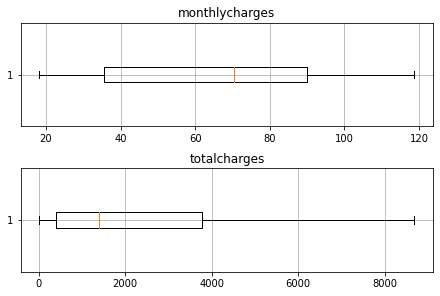

In [21]:
fig, ax = plt.subplots(2,1,constrained_layout=True)
ax[0].boxplot(contract['monthlycharges'], vert=False)
ax[0].set_title('monthlycharges')
ax[0].grid(True)
ax[1].boxplot(contract['totalcharges'], vert=False)
ax[1].set_title('totalcharges')
ax[1].grid(True)
plt.show()

##### Выбросов и аномальных значений нет. Но значения столбца totalcharges не равны умножению monthlycharges на количество месяцев использования сервиса. Это нормально в связи с тем, что где-то были применены скидки.

##### Столбец paperlessbilling сделаем также бинарным.

In [22]:
contract['paperlessbilling'] = contract['paperlessbilling'].map({'yes':1,'no':0})

In [23]:
contract['paperlessbilling'].unique()

array([1, 0])

##### Создадим target - закрыт контракт (1) или нет (0) в столбце contractclosed.

In [24]:
def cclsd(rows):
    if rows['enddate'] == 'No':
        return 0
    else:
        return 1

In [25]:
contract['contractclosed'] = contract.apply(cclsd,axis=1)

##### Создадим признак - время пользования сервисом.

In [26]:
def usagetime(row):
    if row['enddate'] == 'No':
        return int(round(((pd.to_datetime('2020-02-01') - pd.to_datetime(row['begindate']))/np.timedelta64(1,'D')),0))
    else:
        return int(round(((pd.to_datetime(row['enddate']) - pd.to_datetime(row['begindate']))/np.timedelta64(1,'D')),0))

In [27]:
contract['usageperiod'] = contract.apply(usagetime, axis=1)

##### Создам признак - newclient, который подключился в течение последних 6 месяцев.

In [28]:
def newclnt(rows):
    if pd.to_datetime(rows['begindate'])>=pd.to_datetime('2019-08-01'):
        return 1
    else:
        return 0
contract['newclient'] = contract.apply(newclnt,axis=1)

### Personal

# Привести столбцы к признакам

In [29]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


##### Приведем все столбцы к нижнему регистру.

In [30]:
personal.columns = personal.columns.str.lower()

In [31]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


##### Типы данных правильные, пропусков нет.

In [32]:
print(set(contract['customerid']).difference(set(personal['customerid'])))
print(set(personal['customerid']).difference(set(contract['customerid'])))

set()
set()


##### Все customerid совпадают в двух таблицах.

##### Столбец gender переведём в бинарный ismale.

In [33]:
personal['ismale'] = pd.get_dummies(personal['gender'], drop_first=True)

In [34]:
personal = personal.drop('gender',axis=1)

##### Переведём все Yes и No в 1 и 0.

In [35]:
cols = ['partner','dependents']
for i in cols:
    personal[i] = personal[i].map({'Yes':1,'No':0})

In [36]:
personal.head()

,customerid,seniorcitizen,partner,dependents,ismale
0,7590-VHVEG,0,1,0,0
1,5575-GNVDE,0,0,0,1
2,3668-QPYBK,0,0,0,1
3,7795-CFOCW,0,0,0,1
4,9237-HQITU,0,0,0,0


### Создам новый признак - hasfamily, если есть дети и партнер.

In [37]:
def family(row):
    if ((row['partner']==1)&(row['dependents']==1)):
        return 1
    else:
        return 0

In [38]:
personal['hasfamily'] = personal.apply(family,axis=1)

### Internet

In [39]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [40]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [41]:
print(internet['InternetService'].unique())
print(internet['OnlineSecurity'].unique())
print(internet['OnlineBackup'].unique())
print(internet['DeviceProtection'].unique())
print(internet['TechSupport'].unique())
print(internet['StreamingTV'].unique())
print(internet['StreamingMovies'].unique())

['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


##### Значения столбцов в норме.

In [42]:
internet.columns = internet.columns.str.lower()

##### Значения yes и no приведём к 1 и 0.

In [43]:
cols = ['onlinesecurity','onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies']
for i in cols:
    internet[i] = internet[i].map({'Yes':1,'No':0})

### Создам новый признак - количество сервисов.

In [44]:
internet['numofservices'] = internet[['onlinesecurity','onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies']].sum(axis=1).astype('int')
#internet = internet.drop(['onlinesecurity','onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies'],axis=1)

##### Расхождений между internet['customerid'] и personal['customerid'] нет.

In [45]:
print(len(set(internet['customerid']).difference(set(personal['customerid']))))

0


### Phone

In [46]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


##### Приведём названия столбцов к нижнему регистру.

In [47]:
phone.columns = phone.columns.str.lower()

In [48]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


##### Пропущенные значения отсутствуют.

In [51]:
print(len(set(phone['customerid']).difference(set(personal['customerid']))))

0


##### Расхождений между phone['customerid'] и personal['customerid'] нет.

# План работы:
1. После выяснения подробностей про столбцы пойму необходимость каждого признака для обучения модели.
    - Неизвестна важность каждого признака для обучения.
2. Соберу все таблицы в одну с помощью merge.
    - Таким образом получим готовый обучающий датасет.
3. Подготовлю данные для обучения моделей.
    - Кодирование, масштабирование признаков и т.д.
4. Обучение и тюнинг моделей.
5. Получение метрики accuracy.

# Подготовка признаков закончена. Соберу все таблицы в одну для обучения моделей.

In [52]:
data = contract.merge(phone, on='customerid', how='outer', indicator=True)

In [53]:
data['_merge'].unique()

['left_only', 'both']
Categories (2, object): ['left_only', 'both']

##### Объединение прошло успешно. Заполним NaN и удалим столбец _merge.

In [54]:
data['multiplelines'] = data['multiplelines'].fillna('No_phone')
#data['multiplelines'] = data['multiplelines'].astype('int')
data = data.drop('_merge',axis=1)

In [55]:
data = data.merge(personal, on='customerid', how='outer', indicator=True)

In [56]:
print(data['_merge'].unique())
data = data.drop('_merge',axis=1)

['both']
Categories (1, object): ['both']


##### Объединение прошло успешно.

In [57]:
data = data.merge(internet, on='customerid', how='outer', indicator=True)
print(data['_merge'].unique())
data = data.drop('_merge',axis=1)

['both', 'left_only']
Categories (2, object): ['both', 'left_only']


In [58]:
data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,contractclosed,usageperiod,newclient,multiplelines,seniorcitizen,partner,dependents,ismale,hasfamily,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,numofservices
0,7590-VHVEG,2020-01-01,No,month-to-month,1,electronic check,29.85,29.85,0,31,1,No_phone,0,1,0,0,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,5575-GNVDE,2017-04-01,No,one year,0,mailed check,56.95,1889.50,0,1036,0,No,0,0,0,1,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,2.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month-to-month,1,mailed check,53.85,108.15,1,61,1,No,0,0,0,1,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,2.0
3,7795-CFOCW,2016-05-01,No,one year,0,bank transfer (automatic),42.30,1840.75,0,1371,0,No_phone,0,0,0,1,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,3.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month-to-month,1,electronic check,70.70,151.65,1,61,1,No,0,0,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Объединение прошло успешно. Таблицы contract, phone, internet, personal объединены в одну.

In [59]:
data['internetservice'] = data['internetservice'].fillna('No_internet')

In [60]:
data = data.fillna(0)

In [61]:
cols = ['onlinesecurity','onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies','numofservices']
data[cols] = data[cols].astype('int')

# Дополнительное задание:

Телеком: исследование оттока клиентов
Пока создаётся модель прогнозирования оттока клиентов, отдел маркетинга «Ниединогоразрыва.ком» приступает к проработке способов их удержания. Вам предстоит собрать нужную для этого информацию.

1. Сравните распределения величин ежемесячных платежей (MonthlyCharges) всех действующих клиентов и тех, кто ушёл. Для каждой группы посчитайте статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Постройте гистограммы распределения.  
  
  
2. Сравните поведение клиентов этих двух групп. Для каждой постройте два любых графика, изображающих:
    - долю пользователей телефонной связи;
    - долю интернет-пользователей.

### 1. Сравнение распределения платежей всех клиентов.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


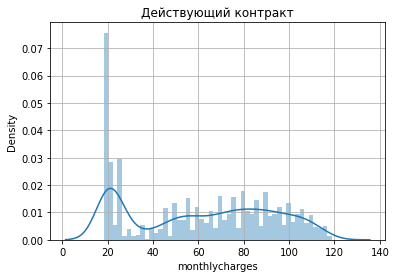

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


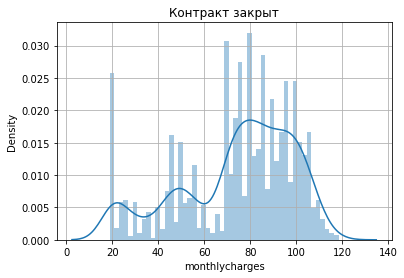

In [62]:
dicts = {0:'Действующий контракт',1:'Контракт закрыт'}
for i in dicts.items():
    ax[i[0]] = sns.distplot(data[data['contractclosed']==i[0]]['monthlycharges'], bins=50)
    ax[i[0]].set_title(str(i[1]))
    ax[i[0]].grid(True)
    plt.show()

In [63]:
for i in dicts.items():
    print(i[1])
    print(data[data['contractclosed']==i[0]]['monthlycharges'].describe(),'\n')

Действующий контракт
count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: monthlycharges, dtype: float64 

Контракт закрыт
count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: monthlycharges, dtype: float64 



##### Выводы:
1. На распределении ежемесячных платежей по контракту отчетливо видно, что среди ушедших абонентов преобладает стоимость услуг больше 60 единиц.  
2. Среди действующих клиентов большинство имеют ежемесячную стоимость в районе 20 единиц.  
3. Для обоих типов контракта минимальная и максимальная стоимость одинаковая.  
4. Среднее значение, медиана, величины 25% и 75% квартилей ежемесячных затрат для ушедших клиентов выше, чем для действующих клиентов.  
5. Таким образом, уходят в основном те, кто много платит ежемесячно.

### Сравниваем поведение клиентов этих двух групп.

Графики:  
    - доля пользователей телефонной связи для обоих типов контракта;
    - доля интернет-пользователей для обоих типов контракта.

##### Доля пользователей интернетом для обоих типов контракта.

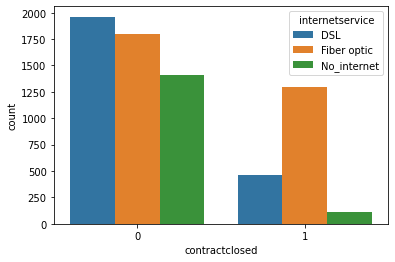

In [64]:
ax = sns.countplot(x="contractclosed", hue="internetservice", data=data)

##### Доля интернет-пользователей для обоих типов контракта.

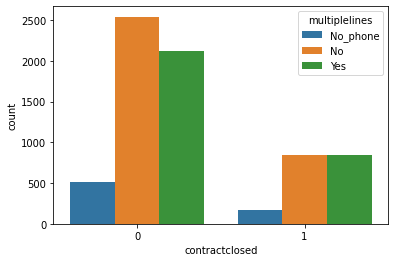

In [65]:
ax = sns.countplot(x="contractclosed", hue="multiplelines", data=data)

##### Выводы:
1. Среди ушедших клиентов было примерно одинаковое количество пользователей телефонной связи и интернета.
2. Среди действующих клиентов доля пользователей телефонной связью немного выше.

# Подготовка данных для обучения моделей.

### Разбиение на features и target выборки.

In [66]:
data = data.reset_index(drop=True)
x = data.drop(['customerid','begindate','enddate','contractclosed'], axis=1)
y = data['contractclosed']

### Кодирование признаков.

In [67]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
cols=['internetservice','multiplelines','paymentmethod','type']
x[cols] = enc.fit_transform(x[cols])
x[cols] = x[cols].astype('int')

### Узнаем необходимое количество категорий для сегментирования пользователей по totalcharges и monthlycharges.

In [68]:
from sklearn.cluster import KMeans
distortion = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(x[['totalcharges']])
    distortion.append(model.inertia_) 

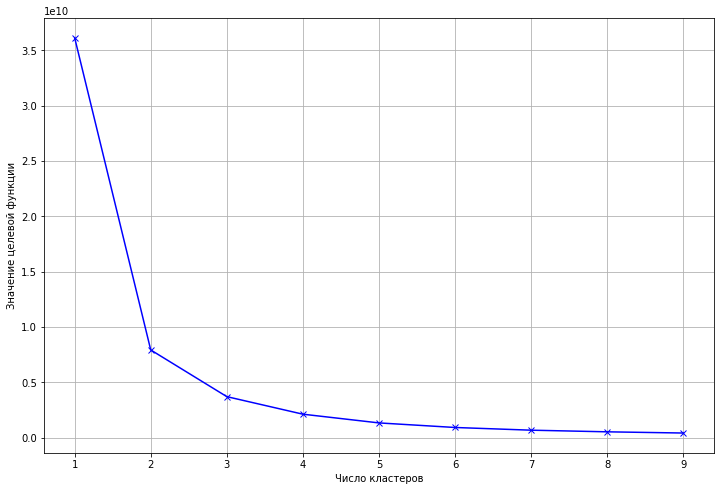

In [69]:
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.grid(True)
plt.show()

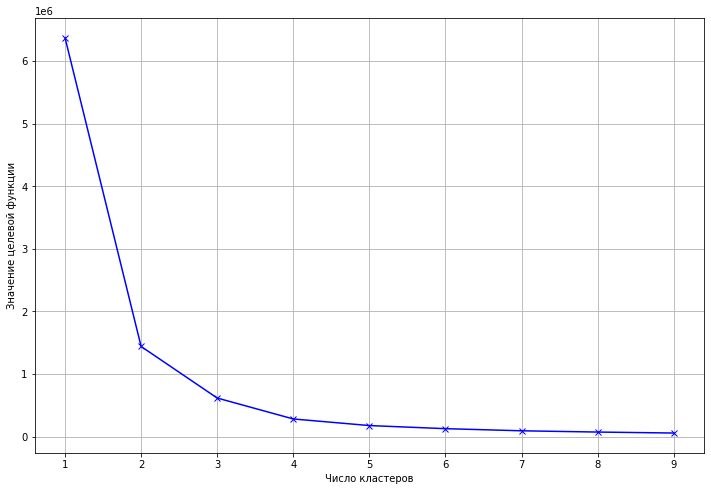

In [70]:
distortion = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(x[['monthlycharges']])
    distortion.append(model.inertia_)
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.grid(True)
plt.show()

### Разделим пользователей на 3 категории.

In [71]:
model = KMeans(n_clusters=3, random_state=12345)
model.fit(x[['type','paymentmethod','totalcharges']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=12345, tol=0.0001, verbose=0)

In [72]:
x['cluster_1'] = model.labels_

### Масштабирование признаков.

In [73]:
scaler = StandardScaler()
cols = ['monthlycharges','totalcharges','usageperiod']
x[cols] = scaler.fit_transform(x[cols])

##### Уменьшение количества признаков - решил не применять.

In [74]:
#len(x.columns)

In [75]:
#pca = PCA(n_components = 20)
#XPCAreduced = pca.fit_transform(x)

In [76]:
#XPCAreduced

##### Посмотрим на корреляцию признаков.

In [77]:
def color_values(val):
    color = 'red' if ((val > 0.6) or (val < -0.6)) else 'black'
    return 'color: %s' % color

In [78]:
x_corr = x.corr()
x_corr.style.applymap(color_values)

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,usageperiod,newclient,multiplelines,seniorcitizen,partner,dependents,ismale,hasfamily,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,numofservices,cluster_1
type,1.000000,-0.176733,-0.227543,-0.074195,0.448106,0.671657,-0.356056,0.110842,-0.142554,0.294806,0.243187,0.000126,0.268192,0.099721,0.245530,0.155085,0.219310,0.293691,0.103944,0.107520,0.284251,0.193009
paperlessbilling,-0.176733,1.000000,-0.062904,0.352150,0.158223,0.006059,-0.035025,0.165146,0.156530,-0.014877,-0.111377,-0.011754,-0.096159,-0.138625,-0.003636,0.126735,0.103797,0.037880,0.223841,0.211716,0.182481,0.140838
paymentmethod,-0.227543,-0.062904,1.000000,-0.193407,-0.330824,-0.370402,0.266082,-0.176793,-0.038551,-0.154798,-0.040292,0.017352,-0.068157,0.086140,-0.150100,-0.170898,-0.181085,-0.157272,-0.148865,-0.154984,-0.245968,-0.241871
monthlycharges,-0.074195,0.352150,-0.193407,1.000000,0.651262,0.247754,-0.196264,0.433576,0.220173,0.096848,-0.113890,-0.014569,-0.072433,-0.323260,0.296594,0.441780,0.482692,0.338304,0.629603,0.627429,0.724706,0.476154
totalcharges,0.448106,0.158223,-0.330824,0.651262,1.000000,0.825622,-0.457107,0.452893,0.102761,0.318103,0.063133,-0.000267,0.115821,-0.176139,0.412260,0.509846,0.522581,0.432470,0.515504,0.520088,0.745565,0.623803
usageperiod,0.671657,0.006059,-0.370402,0.247754,0.825622,1.000000,-0.589555,0.342921,0.016514,0.379709,0.159766,0.005111,0.210531,-0.030334,0.327203,0.360238,0.360602,0.324238,0.279657,0.286007,0.494190,0.543697
newclient,-0.356056,-0.035025,0.266082,-0.196264,-0.457107,-0.589555,1.000000,-0.246736,-0.027824,-0.262825,-0.119704,0.000158,-0.150734,0.020642,-0.198421,-0.220830,-0.240651,-0.200653,-0.208415,-0.212306,-0.327409,-0.367938
multiplelines,0.110842,0.165146,-0.176793,0.433576,0.452893,0.342921,-0.246736,1.000000,0.146185,0.142410,-0.024991,-0.006739,0.004522,-0.109216,0.131128,0.226910,0.231661,0.134768,0.274823,0.279727,0.329273,0.276155
seniorcitizen,-0.142554,0.156530,-0.038551,0.220173,0.102761,0.016514,-0.027824,0.146185,1.000000,0.016479,-0.211185,-0.001874,-0.178852,-0.032310,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,0.067493,0.099340
partner,0.294806,-0.014877,-0.154798,0.096848,0.318103,0.379709,-0.262825,0.142410,0.016479,1.000000,0.452676,-0.001808,0.594629,0.000891,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,0.204237,0.191839


Выводы:
1. По результатам её исследования я удалил добавленные ранее признаки, которые ухудшили обучение модели.
2. Удаление любого из представленных тут коррелирующих признаков приводит к ухудшению показателей модели.
3. Получилось, что корреляция хоть и есть, но "из песни слов не выкинешь". Все признаки нужны и важны для результата модели.</font>

### Разбиение на train, valid, test выборки.

In [79]:
x_train, x_tosplit, y_train, y_tosplit = train_test_split(x, y, test_size=0.4, random_state=12345)
x_valid, x_test, y_valid, y_test = train_test_split(x_tosplit, y_tosplit, test_size=0.5, random_state=12345)

In [80]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(4225, 22)
(1409, 22)
(1409, 22)
(4225,)
(1409,)
(1409,)


### RandomForest Classifier

In [81]:
def trainrfc(x_train, y_train, n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf,random_state):
    model = RandomForestClassifier(n_jobs=-1,class_weight='balanced',n_estimators=n_estimators,criterion=criterion,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,random_state=random_state)
    model.fit(x_train,y_train)
    return model

In [82]:
#n_estimators = [250,260]
##criterion = ['gini','entropy']
#rst = [100,110,120,130]
#max_depth = [100,180,200,220]
#min_samples_split = [4,5,6,7,8]
#min_samples_leaf = [6,7,8,9,10]

In [83]:
#%%time
#tab = pd.DataFrame(columns = ['n_estimators','random_state','max_depth','min_samples_split','min_samples_leaf','accuracy','ROC_AUC'])
#counter=0
#for a in n_estimators:
#    for b in rst:
#        for c in max_depth:
#            for d in min_samples_split:
#                for e in min_samples_leaf:
#                    model = trainrfc(x_train, y_train, a,'entropy', c, d, e, b)
#                    scoring = accuracy_score(y_valid, model.predict(x_valid))
#                    probabilities_valid = model.predict_proba(x_valid)[:, 1]
#                    roc_auc = roc_auc_score(y_valid, probabilities_valid) 
#                    tab = tab.append({'n_estimators':a,'random_state':b,'max_depth':c,'min_samples_split':d,'min_samples_leaf':e,'accuracy':scoring,'ROC_AUC':roc_auc}, ignore_index=True)
#                    print(counter,a,b,c,d,e,scoring,roc_auc)
#                    counter += 1
#print(tab.sort_values('ROC_AUC', ascending=False).head(20))

In [84]:
#tab.sort_values('ROC_AUC', ascending=False).head(50)

In [85]:
#n_estimators = [150,160,170,180,200,250,260]
#max_depth = [100,150,180,190,200]
#min_samples_split = [2,3,4,5,6,7]

In [86]:
#%%time
#tab = pd.DataFrame(columns = ['n_estimators','max_depth','min_samples_split','accuracy','ROC_AUC'])
#counter=0
#for a in n_estimators:
#    for c in max_depth:
#        for d in min_samples_split:
#            model = trainrfc(x_train, y_train, a,'entropy', c, d, 7, 100)
#            scoring = accuracy_score(y_valid, model.predict(x_valid))
#            probabilities_valid = model.predict_proba(x_valid)[:, 1]
#            roc_auc = roc_auc_score(y_valid, probabilities_valid) 
#            tab = tab.append({'n_estimators':a,'max_depth':c,'min_samples_split':d,'accuracy':scoring,'ROC_AUC':roc_auc}, ignore_index=True)
#            print(counter,a,c,d,scoring,roc_auc)
#            counter += 1
#print(tab.sort_values('ROC_AUC', ascending=False).head(20))

In [87]:
#print(tab.sort_values('ROC_AUC', ascending=False).head(50))

### KNeighborsClassifier

In [88]:
#n_neighbors = [5,10,15,20,50,70,100]

In [89]:
#acc = pd.DataFrame(columns = ['n_neighbors','accuracy','ROC_AUC'])
#counter=0
#for i in n_neighbors:
#    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
#    knn.fit(x_train, y_train)
#    scoring = accuracy_score(y_valid, knn.predict(x_valid))
#    probabilities_valid = knn.predict_proba(x_valid)[:, 1]
#    roc_auc = roc_auc_score(y_valid, probabilities_valid) 
#    acc = acc.append({'n_neighbors':i,'accuracy':scoring,'ROC_AUC':roc_auc}, ignore_index=True)
#    print(counter,i,scoring,roc_auc)
#    counter += 1
#print(acc.sort_values('ROC_AUC', ascending=False).head(10))

### SVM.svc

In [90]:
#C = [1,2,3,4,5,6,7,8,9,10]
#kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

In [91]:
#best = pd.DataFrame(columns = ['C','kernel','accuracy','ROC_AUC'])
#counter=0
#for i in C:
#    for k in kernel:
#        clf = SVC(class_weight='balanced',probability=True,random_state=12345)
#        clf.fit(x_train, y_train)
#        scoring = accuracy_score(y_valid, clf.predict(x_valid))
#        probabilities_valid = clf.predict_proba(x_valid)[:, 1]
#        roc_auc = roc_auc_score(y_valid, probabilities_valid) 
#        best = best.append({'C':i,'kernel':k,'accuracy':scoring,'ROC_AUC':roc_auc}, ignore_index=True)
#        print(counter,i,k,scoring,roc_auc)
#        counter += 1
#print(best.sort_values('ROC_AUC', ascending=False).head(20))

### CatBoost

In [92]:
def catbst(x_train,y_train,x_valid,y_valid,iterations,depth,l2_leaf_reg):
    model = CatBoostClassifier(verbose=1000,iterations=iterations, depth=depth, l2_leaf_reg=l2_leaf_reg, random_state=100)
    model.fit(x_train, y_train, use_best_model=True, eval_set=(x_valid,y_valid))
    return model

In [93]:
#iterations = [400,500]
#depth = [2,3,4,5]
#min_data_in_leaf = [1,3,5,7]
#l2_leaf_reg = [3,4,5,6]

In [94]:
#%%time
#acc = pd.DataFrame(columns = ['depth','iterations','l2_leaf_reg','accuracy','ROC_AUC'])
#counter = 0
#for i in iterations:
#    for j in depth:
#        for l in l2_leaf_reg:
#            model = catbst(x_train, y_train, x_valid, y_valid, i, j, l)
#            scoring = accuracy_score(y_valid, model.predict(x_valid))
#            probabilities_valid = model.predict_proba(x_valid)[:, 1]
#            roc_auc = roc_auc_score(y_valid, probabilities_valid) 
#            acc = acc.append({'depth':j,'iterations':i,'l2_leaf_reg':l,'accuracy':scoring,'ROC_AUC':roc_auc}, ignore_index=True)
#            print(counter,i,j,l,scoring,roc_auc)
#            counter += 1
#print(acc.sort_values('ROC_AUC', ascending=False))

In [95]:
#print(acc.sort_values('ROC_AUC', ascending=False))

##### Лучший результат по сравнению с другими показала модель CatBoost с параметрами iterations=3000, depth=5, l2_leaf_reg = 3.  
Accuracy = 0.899929  
ROC_AUC = 0.947246

# Проверка модели.

In [96]:
def catbst(x_train,y_train,x_valid,y_valid,iterations,depth,l2_leaf_reg):
    model = CatBoostClassifier(verbose=1000,iterations=iterations, depth=depth, l2_leaf_reg=l2_leaf_reg, random_state=100)
    model.fit(x_train, y_train, use_best_model=True, eval_set=(x_valid,y_valid))
    return model

In [97]:
model = catbst(x_train, y_train, x_valid, y_valid, 3000, 3, 5)

0:	learn: 0.6775986	test: 0.6779310	best: 0.6779310 (0)	total: 50ms	remaining: 2m 29s
1000:	learn: 0.2693167	test: 0.3167477	best: 0.3167477 (1000)	total: 2.28s	remaining: 4.55s
2000:	learn: 0.2225352	test: 0.2979193	best: 0.2978752 (1997)	total: 4.48s	remaining: 2.24s
2999:	learn: 0.1941406	test: 0.2932414	best: 0.2927445 (2912)	total: 6.72s	remaining: 0us

bestTest = 0.2927444515
bestIteration = 2912

Shrink model to first 2913 iterations.


In [98]:
scoring = accuracy_score(y_valid, model.predict(x_valid))
probabilities_valid = model.predict_proba(x_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, probabilities_valid)
print(scoring, roc_auc)

0.8757984386089425 0.9237778921985962


##### На валидационной выборке ROC_AUC получился 0.9237778921985962.

### Применю обучение модели на объединённой тренировочной + валидационной выборках для проверки показателей на тестовой выборке.

In [99]:
x_new = pd.concat([x_train, x_valid], ignore_index=True)
y_new = pd.concat([y_train, y_valid], ignore_index=True)

In [100]:
cols=['internetservice','multiplelines','paymentmethod','type']
x_new[cols] = x_new[cols].astype('int')
x_test[cols] = x_test[cols].astype('int')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [101]:
def catbst_new(x_train,y_train,iterations,depth,l2_leaf_reg):
    model = CatBoostClassifier(cat_features=['paymentmethod','internetservice','type','multiplelines'],verbose=1000,iterations=iterations, depth=depth, l2_leaf_reg=l2_leaf_reg, random_state=100)
    model.fit(x_train, y_train)
    return model

In [102]:
c_boost = catbst_new(x_new, y_new, 3000, 3, 5)

0:	learn: 0.6780332	total: 5.91ms	remaining: 17.7s
1000:	learn: 0.2964864	total: 5.39s	remaining: 10.8s
2000:	learn: 0.2588238	total: 11s	remaining: 5.47s
2999:	learn: 0.2325561	total: 16.7s	remaining: 0us


In [103]:
scoring = accuracy_score(y_test, c_boost.predict(x_test))
probabilities_valid = c_boost.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities_valid)
print(scoring, roc_auc)

0.8821859474804826 0.9225456976585173


##### А на тестовой ROC_AUC - 0.9225456976585173, accuracy - 0.8821859474804826.

# Общий вывод:
1. У провайдера наблюдается существенный спад по новым клиентам. Многие из тех, кто подключился за последние пять месяцев, закрыли контракт.
2. В 2019 году начался активный прикток новых клиентов, которые, возможно, привели к ухудшению качества предоставляемых услуг.
3. Исходные данные были изучены и предобработаны.
4. Были созданы дополнительные признаки, исходя из анализа представленных материалов.
5. Были опробованы модели машинного обучения RandomForestClassifier, KNeighborsClassifier, SVM.svc, CatBoost.
6. Наилучший результат с большим отрывом показала модель CatBoost.
7. Удалось достигнуть значений accuracy 0.8821859474804826 и ROC_AUC 0.9225456976585173 на тестовой выборке.

### Вывод графика важности признаков для обучения модели.

In [104]:
features = pd.DataFrame(columns=['name','importance'])
features['importance'] = c_boost.get_feature_importance()
features['name'] = x_train.columns
features = features.sort_values('importance',ascending=False)

Text(0, 0.5, 'Feature importance')

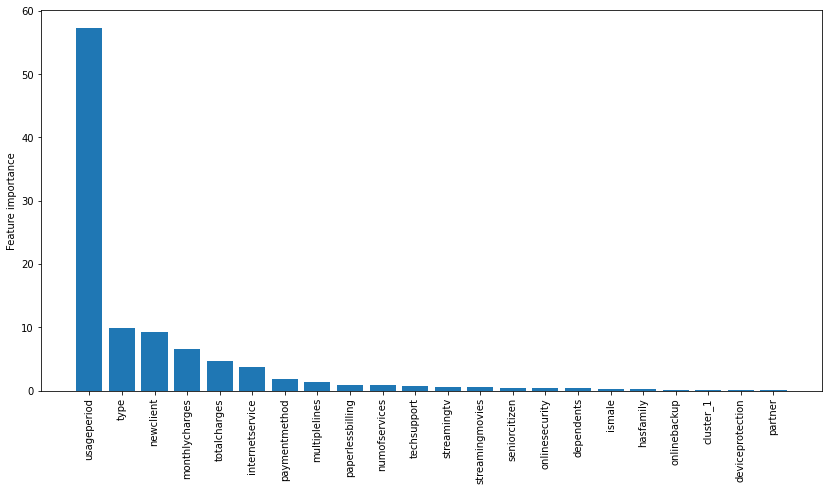

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(len(features)), height=features['importance'])
ax.set_xticklabels(features['name'], rotation=90)
ax.set_xticks(np.arange(len(features)))
ax.set_ylabel('Feature importance')